In [1]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from functools import partial
from multiprocessing import Pool
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import RepeatedKFold
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

## Personal Modules
import ReadStandardTimeFill as RSTF
# import LSTM_Train as LSTM
import importlib
import LSTM
importlib.reload(LSTM)

%matplotlib inline
%config IPCompleter.greedy=True

from scipy.optimize import minimize
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from matplotlib import cm


def upper_confidence_bound(mu_x, sigma_x, opt_value, kappa=-1.0):
    return mu_x + kappa * sigma_x


# kernel = Matern()#length_scale = [1,1],length_scale_bounds="fixed")
# kernel = ConstantKernel(1e0, (1e-2, 1e2))*Matern(1e1, (1e-4, 1e4),nu = 2.5)\
# + WhiteKernel(noise_level=1e0, noise_level_bounds=(1e-2, 1e2))
acq = upper_confidence_bound
def query(xi, yi, gp):
    best_value = np.inf

    for N in np.linspace(1,params['N_Max']):
        for T in np.linspace(0,params['T_Max']):
            def obj(x):
                x=x.reshape(1,-1)
                mu_x, sigma_x = gp.predict(x, return_std=True)
#                 print(np.min(yi),np.max(yi))
                return acq(mu_x, sigma_x, np.min(yi))
            x0 = np.asanyarray([N,T]).reshape(1,2)
            res = minimize(obj, x0, bounds=((1, params['N_Max']),(0,params['T_Max'])))

            if res.fun < best_value:
                best_value = res.fun
                query_point = res.x
    query_point = query_point
    return query_point



      N   T  MSE  STD
0    39  36  0.0  0.0
1    21  37  0.0  0.0
2     7  12  0.0  0.0
3    33  11  0.0  0.0
4    95  33  0.0  0.0
5   101  14  0.0  0.0
6    58  14  0.0  0.0
7    34  34  0.0  0.0
8    11  12  0.0  0.0
9    43  11  0.0  0.0
10   41   2  0.0  0.0
11   19  25  0.0  0.0
12   15  33  0.0  0.0
13   72  21  0.0  0.0
14   21  26  0.0  0.0
{'epochs': 600, 'N_Min': 2, 'Y': 'fch4', 'Searches': 8, 'reps': 15, 'T_Max': 48, 'proc': 3, 'N_Max': 100}


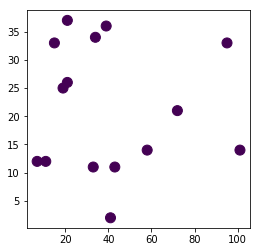

In [2]:
FillVar = 'fch4'
Runs,params = LSTM.Params('Full',FillVar,MP=True)# rpms.Runs,rpms.params
Runs['MSE'] = 0.0
Runs['STD'] = 0.0
print(Runs)
print(params)
plt.figure(figsize = (4,4))
plt.scatter(Runs["N"],Runs['T'],s=100,c=Runs['MSE'])

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


Finisehed Run  0
Finisehed Run  1
Finisehed Run  2
Finisehed Run  3
Finisehed Run  4
Finisehed Run  5
Finisehed Run  6
Finisehed Run  7
Finisehed Run  8
Finisehed Run  9
Finisehed Run  10
Finisehed Run  11
Finisehed Run  12
Finisehed Run  13


Using TensorFlow backend.


Finisehed Run  14
      N   T       MSE       STD
0    39  36  0.664565  0.115512
1    21  37  0.631835  0.133452
2     7  12  0.643220  0.133826
3    33  11  0.611226  0.107130
4    95  33  0.683416  0.196926
5   101  14  0.572953  0.080333
6    58  14  0.568454  0.075945
7    34  34  0.552356  0.084769
8    11  12  0.595192  0.110804
9    43  11  0.597947  0.097424
10   41   2  0.516738  0.086529
11   19  25  0.594752  0.075982
12   15  33  0.640345  0.141815
13   72  21  0.577417  0.137323
14   21  26  0.598208  0.114595


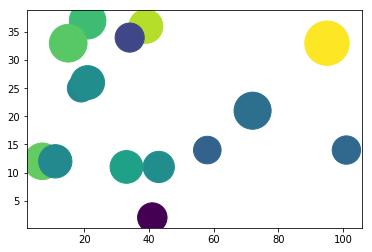

Using TensorFlow backend.


In [3]:
def TTV_Split(i,Memory,X,y,params,X_fill):
    X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.1, random_state=i)
    X_train,X_val,y_train,y_val=train_test_split(X_train,y_train, test_size=0.11, random_state=i)
    return(LSTM.Train_Steps(params['epochs'],params['N'],X_train,X_test,X_val,y_train,y_test,
                            y_val,i,X_fill = X_fill,Memory=Memory))


AllVars = ['H','LE','Fco2','fco2','fch4','Wind Spd','air pressure','Ta','Rn','PPFD','Rain','Water Table','Ts 2.5 cm',
         'Ts 15 cm','VWC','Active Layer','24H Rain','Wtr Tbl Trnd','ET']

FullModel = ['Wind Spd','air pressure','Ta','PPFD','Ts 2.5 cm','Ts 15 cm',
         'VWC','Active Layer','Rain','Water Table']

# FullModel = ['Wind Spd','air pressure','Water Table','PPFD','Ts 2.5 cm']

Time = time.time()
Path = 'FilteredData2018-04-04.csv'

def RunReps(Model,params,pool = None,plot=False,FullReturn=False):
    RST = RSTF.ReadStandardTimeFill(Path)
    offset = 5/params['proc']
    Memory = (math.floor(100/params['proc'])- offset) * .01
    MSE = []
    RST.Scale(params['Y'],Model)
    RST.TimeShape(params['T'])
    y = RST.y_time.copy()#*1.0
    X = RST.X_time.copy()#*1.0
    X_fill = RST.X_ftime.copy()
    MSE = []
    STD = []
    Y_fill = []
    if __name__=='__main__'and params['proc'] != 1:
        for i,results in enumerate(pool.imap(partial(TTV_Split,Memory=Memory,X=X,y=y,params=params,X_fill=X_fill),
                                             range(params['reps']))):
            mse = results[0]
            y_fill = results[1]
            Y_fill.append(y_fill)
            MSE.append(mse)
    else:
        for i in range(params['reps']):
            results = TTV_Split(i,Memory,X,y,params,X_fill)
            mse = results[0]
            MSE.append(mse)
            y_fill = results[1]
            Y_fill.append(y_fill)
    MSE = np.asanyarray(MSE)
    Y_fill = np.asanyarray(Y_fill)
    Y_fill = Y_fill.mean(axis=0)
    FillVarName = 'Fch4'
    RST.Fill(Y_fill,FillVarName)
    if plot == True:
        plt.figure(figsize=(5,5))
        plt.plot(RST.Master['Fch4'],color='red')
#         plt.plot(RST.Master['fch4'],color='grey')
        plt.plot(RST.Master['TempFill'],color='blue',alpha=.5)  # This works
        
        yl = plt.ylim()
#         plt.xlim(yl[0],yl[1])
        plt.grid()
    if FullReturn == False:
        return(MSE,RST.Master['TempFill'])
    else:
        return(MSE,RST.Master)

if __name__=='__main__'and params['proc'] != 1:
    pool = Pool(processes=params['proc'],maxtasksperchild=75)
else:pool=None
    
for i in Runs.index:
    params['T']=Runs['T'].iloc[i]
    params['N']=Runs['N'].iloc[i]
    Results = RunReps(FullModel,params,pool)
    MSE = Results[0]
    Runs['MSE'][i]=MSE.mean()
    Runs['STD'][i]=MSE.std()
    print('Finisehed Run ',str(i))

print(Runs)
plt.scatter(Runs['N'],Runs['T'],c=Runs['MSE'],s=Runs['STD']*1e4)

[ 41.4896637    4.30135377]
41 4


Using TensorFlow backend.


[ 43.28278211   2.69675828]
43 3
[ 38.70510464   2.69119432]
39 3
[ 39.48651446   0.08199546]
39 0
[ 36.85206713   0.8053603 ]
37 1
[ 41.57004368   0.        ]
42 0
[ 44.402   0.   ]
44 0
[ 46.51473291   0.        ]
47 0
         MSE    N       STD   T
0   0.643220    7  0.133826  12
1   0.595192   11  0.110804  12
2   0.640345   15  0.141815  33
3   0.594752   19  0.075982  25
4   0.598208   21  0.114595  26
5   0.631835   21  0.133452  37
6   0.611226   33  0.107130  11
7   0.552356   34  0.084769  34
8   0.539487   37  0.088275   1
9   0.496697   39  0.098395   0
10  0.558573   39  0.082204   3
11  0.664565   39  0.115512  36
12  0.516738   41  0.086529   2
13  0.540570   41  0.119595   4
14  0.499359   42  0.104939   0
15  0.585952   43  0.117487   3
16  0.597947   43  0.097424  11
17  0.506206   44  0.108527   0
18  0.502281   47  0.105629   0
19  0.568454   58  0.075945  14
20  0.577417   72  0.137323  21
21  0.683416   95  0.196926  33
22  0.572953  101  0.080333  14
Optimum:
  

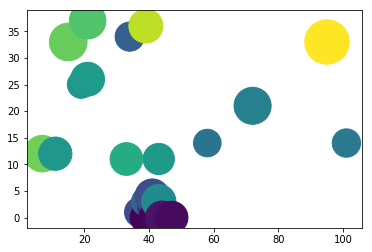

In [4]:

for i in range(params['Searches']):
    kernel = Matern(length_scale_bounds="fixed") 
    gp = GaussianProcessRegressor(kernel=kernel, alpha=Runs['STD'].values, random_state=1,normalize_y=True)
    gp.fit(Runs[['N','T']].values, Runs['MSE'].values)
    
    next_x = query(Runs[['N','T']].values, Runs['MSE'].values, gp)
    print(next_x)
    N = int(np.round(next_x[0],0))
    T = int(np.round(next_x[1],0))
    o = 0
    while len(Runs.loc[(Runs['N']==N) & (Runs['T']==T)].index) != 0:
        print('Adjust!')
        o +=1
        N += int(o*np.cos(o*np.pi))
        if N < params['N_Min'] or N > params['N_Max']:
            N -= int(o*np.cos(o*np.pi))
        if o > 5:
            T += 1
    print(N,T)
    d = {'N':N,'T':T,'MSE':0,'STD':0}
    idx = Runs.index[-1] + 1
    D2 = pd.DataFrame(data=d,index=[idx])
    Runs = Runs.append(D2)
    
    params['T'] = T
    params['N'] = N
    
    Results = RunReps(FullModel,params,pool)
    MSE = Results[0]
    
    Runs['MSE'][idx]=MSE.mean()
    Runs['STD'][idx]=MSE.std()
    
    Runs = Runs.sort_values(by = ['N','T']).reset_index(drop=True)
    
print(Runs)
Optimum = Runs[Runs['MSE'] == Runs['MSE'].min()]
print('Optimum:')
print(Optimum)
plt.scatter(Runs['N'],Runs['T'],c=Runs['MSE'],s=Runs['STD']*1e4)

['Wind Spd', 'air pressure', 'Ta', 'PPFD', 'Ts 2.5 cm', 'Ts 15 cm', 'VWC', 'Active Layer', 'Rain', 'Water Table']
Level:  1

['Wind Spd']

['air pressure']

['Ta']

['PPFD']

['Ts 2.5 cm']

['Ts 15 cm']


Using TensorFlow backend.



['VWC']


Using TensorFlow backend.



['Active Layer']


Using TensorFlow backend.



['Rain']

['Water Table']
Best:
['PPFD'] 0.740633157949
Level:  2

['Wind Spd', 'PPFD']

['air pressure', 'PPFD']

['Ta', 'PPFD']

['PPFD', 'Ts 2.5 cm']

['PPFD', 'Ts 15 cm']

['PPFD', 'VWC']

['PPFD', 'Active Layer']

['PPFD', 'Rain']

['PPFD', 'Water Table']
Best:
['Wind Spd', 'PPFD'] 0.687858130936
Level:  3

['Wind Spd', 'air pressure', 'PPFD']

['Wind Spd', 'Ta', 'PPFD']


Using TensorFlow backend.



['Wind Spd', 'PPFD', 'Ts 2.5 cm']


Using TensorFlow backend.



['Wind Spd', 'PPFD', 'Ts 15 cm']


Using TensorFlow backend.



['Wind Spd', 'PPFD', 'VWC']

['Wind Spd', 'PPFD', 'Active Layer']

['Wind Spd', 'PPFD', 'Rain']

['Wind Spd', 'PPFD', 'Water Table']
Best:
['Wind Spd', 'PPFD', 'Active Layer'] 0.626269901426
Level:  4

['Wind Spd', 'air pressure', 'PPFD', 'Active Layer']

['Wind Spd', 'Ta', 'PPFD', 'Active Layer']

['Wind Spd', 'PPFD', 'Ts 2.5 cm', 'Active Layer']

['Wind Spd', 'PPFD', 'Ts 15 cm', 'Active Layer']

['Wind Spd', 'PPFD', 'VWC', 'Active Layer']

['Wind Spd', 'PPFD', 'Active Layer', 'Rain']

['Wind Spd', 'PPFD', 'Active Layer', 'Water Table']
Best:
['Wind Spd', 'air pressure', 'PPFD', 'Active Layer'] 0.593766850293
Level:  5

['Wind Spd', 'air pressure', 'Ta', 'PPFD', 'Active Layer']

['Wind Spd', 'air pressure', 'PPFD', 'Ts 2.5 cm', 'Active Layer']


Using TensorFlow backend.



['Wind Spd', 'air pressure', 'PPFD', 'Ts 15 cm', 'Active Layer']


Using TensorFlow backend.



['Wind Spd', 'air pressure', 'PPFD', 'VWC', 'Active Layer']


Using TensorFlow backend.



['Wind Spd', 'air pressure', 'PPFD', 'Active Layer', 'Rain']

['Wind Spd', 'air pressure', 'PPFD', 'Active Layer', 'Water Table']
Best:
['Wind Spd', 'air pressure', 'PPFD', 'Active Layer', 'Water Table'] 0.528741250174
Level:  6

['Wind Spd', 'air pressure', 'Ta', 'PPFD', 'Active Layer', 'Water Table']

['Wind Spd', 'air pressure', 'PPFD', 'Ts 2.5 cm', 'Active Layer', 'Water Table']

['Wind Spd', 'air pressure', 'PPFD', 'Ts 15 cm', 'Active Layer', 'Water Table']

['Wind Spd', 'air pressure', 'PPFD', 'VWC', 'Active Layer', 'Water Table']

['Wind Spd', 'air pressure', 'PPFD', 'Active Layer', 'Rain', 'Water Table']
Best:
['Wind Spd', 'air pressure', 'PPFD', 'Ts 2.5 cm', 'Active Layer', 'Water Table'] 0.525596268349
Level:  7

['Wind Spd', 'air pressure', 'Ta', 'PPFD', 'Ts 2.5 cm', 'Active Layer', 'Water Table']

['Wind Spd', 'air pressure', 'PPFD', 'Ts 2.5 cm', 'Ts 15 cm', 'Active Layer', 'Water Table']

['Wind Spd', 'air pressure', 'PPFD', 'Ts 2.5 cm', 'VWC', 'Active Layer', 'Water Tabl

Using TensorFlow backend.



['Wind Spd', 'air pressure', 'PPFD', 'Ts 2.5 cm', 'Ts 15 cm', 'VWC', 'Active Layer', 'Water Table']

['Wind Spd', 'air pressure', 'PPFD', 'Ts 2.5 cm', 'VWC', 'Active Layer', 'Rain', 'Water Table']
Best:
['Wind Spd', 'air pressure', 'Ta', 'PPFD', 'Ts 2.5 cm', 'VWC', 'Active Layer', 'Water Table'] 0.511663149941
Level:  9

['Wind Spd', 'air pressure', 'Ta', 'PPFD', 'Ts 2.5 cm', 'Ts 15 cm', 'VWC', 'Active Layer', 'Water Table']


Using TensorFlow backend.
Using TensorFlow backend.



['Wind Spd', 'air pressure', 'Ta', 'PPFD', 'Ts 2.5 cm', 'VWC', 'Active Layer', 'Rain', 'Water Table']
Best:
['Wind Spd', 'air pressure', 'Ta', 'PPFD', 'Ts 2.5 cm', 'Ts 15 cm', 'VWC', 'Active Layer', 'Water Table'] 0.496501975081
Level:  10

['Wind Spd', 'air pressure', 'Ta', 'PPFD', 'Ts 2.5 cm', 'Ts 15 cm', 'VWC', 'Active Layer', 'Rain', 'Water Table']
Best:
['Wind Spd', 'air pressure', 'Ta', 'PPFD', 'Ts 2.5 cm', 'Ts 15 cm', 'VWC', 'Active Layer', 'Rain', 'Water Table'] 0.496708674764
          CI       MSE                                             Models
1   0.087558  0.740633                                        Model: PPFD
2   0.078976  0.687858                               Model: Wind Spd+PPFD
3   0.079336  0.626270                  Model: Wind Spd+PPFD+Active Layer
4   0.072829  0.593767     Model: Wind Spd+air pressure+PPFD+Active Layer
5   0.061484  0.528741  Model: Wind Spd+air pressure+PPFD+Active Layer...
6   0.058545  0.525596  Model: Wind Spd+air pressure+PPFD+Ts 2.5 

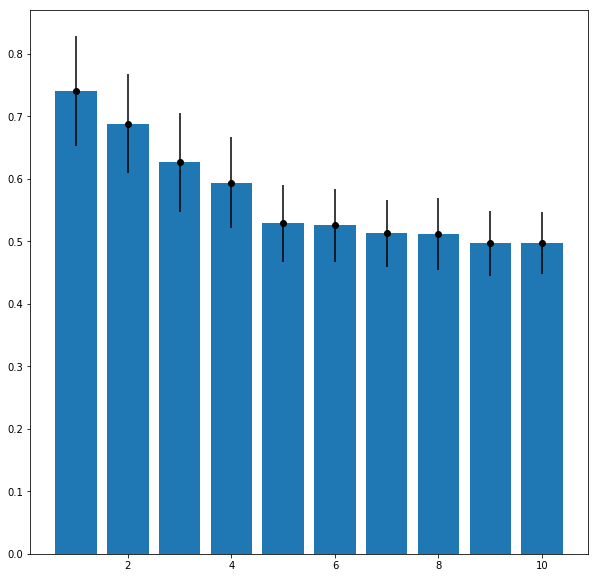

In [5]:
def Combos(Model,L,factor=None):
    Models=list()
    for c in combinations(Model,L):
        c = list(c)
        if factor == None:
            Models.append(c)
        else:
            if set(factor).issubset(set(c)):
#             if factor in c:
                Models.append(c)
    return(Models)
params['T']=Optimum['T'].values[0]
params['N']=Optimum['N'].values[0]


Results = RunReps(FullModel,params,pool,FullReturn=True)
FullScore = Results[0]
Data = Results[1]


BestMSE = []
BestSTD = []
idx = []
BestModels = []

print(FullModel)

for i in range(1,len(FullModel)+1):
    print('Level: ',i)
    if i == 1:
        Models = Combos(FullModel,i)
    else:
        Models = Combos(FullModel,i,factor = Best)
#     for model in Models:
    Score = []
    STD = []
    Model_Names = []
    
    for model in Models:
        print()
        print(model)
        Results = RunReps(model,params,pool)
        MSE = Results[0]
        Score.append(MSE.mean())
        STD.append(MSE.std())
        Data['Model: '+'+'.join(model)] = Results[1]
        Model_Names.append('Model: '+'+'.join(model))
        
    Score = np.asanyarray(Score)
    STD = np.asanyarray(STD)
#     print(Model_Names)
#     print(np.where(Score == Score.min())[0][0])
    Best = Models[np.where(Score == Score.min())[0][0]]
    Best_Name = Model_Names[np.where(Score == Score.min())[0][0]]
    BestModels.append(Best_Name)
    BestMSE.append(Score.min())
    BestSTD.append(STD[np.where(Score == Score.min())[0][0]])
    idx.append(i)
    print('Best:')
    print(Best,Score.min())
BestModels = np.asanyarray(BestModels)
BestMSE = np.asanyarray(BestMSE)
BestSTD = np.asanyarray(BestSTD)
idx = np.asanyarray(idx)
BestSE = BestSTD/(params['reps']**.5)
BestCI = BestSE*1.96
plt.figure(figsize=(10,10))
plt.bar(idx,BestMSE)
plt.errorbar(idx,BestMSE,yerr=BestCI,color = 'black',fmt='o')

d = {'Models':BestModels,'MSE':BestMSE,'CI':BestCI}
Stats = pd.DataFrame(index=idx,data=d)
Stats.to_csv('GapFillingSummary'+FillVar+'.csv')
print(Stats)

Data.to_csv('GapFilled'+FillVar+'.csv')

In [6]:

if __name__=='__main__'and params['proc'] != 1:
    pool.close()

print(time.time()-Time)
        

6881.1463923454285


In [7]:

# d = {'Models':BestModels,'MSE':BestMSE,'STD':BestSTD}
# Stats = pd.DataFrame(index=idx,data=d)
# Stats.to_csv('GapFillingSummary'+FillVar+'.csv')
# print(Stats)

In [8]:
print(Score)

[ 0.49670867]


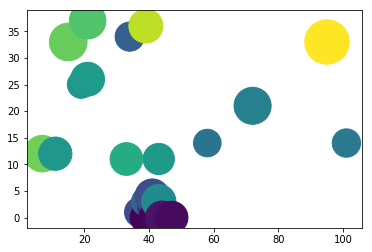

In [9]:

d = {'Models':BestModels,'MSE':BestMSE,'CI':BestCI}
Stats = pd.DataFrame(index=idx,data=d)
Stats.to_csv('GapFillingSummary'+FillVar+'.csv')
# gp = GaussianProcessRegressor(kernel=kernel, alpha=Runs['STD'].values, random_state=1,normalize_y=True)
# 

# gp.fit(Runs[['N','T']].values, Runs['MSE'].values)

# next_x = query(Runs[['N','T']].values, Runs['MSE'].values, gp)
# print(next_x)
plt.scatter(Runs['N'],Runs['T'],c=Runs['MSE'],s=Runs['STD']*1e4)